In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import requests
import aiohttp
import asyncio
import ujson as json
import QuantLib as ql
import warnings
from scipy.interpolate import interp1d, PchipInterpolator
from datetime import datetime, timedelta
from typing import List, Optional
from collections import OrderedDict

from fetch_treasuries import multi_download_year_treasury_par_yield_curve_rate
from utils import plot_yield_curves

import nest_asyncio
nest_asyncio.apply()

sns.set(style="whitegrid", palette="dark")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
dir_path = r"C:\Users\chris\tactical-treasuries-treasure\data" 
years = [str(x) for x in range(2024, 1989, -1)]
ust_daily_data = multi_download_year_treasury_par_yield_curve_rate(years, dir_path, run_all=True)

In [76]:
df_par_rates = ust_daily_data["daily_treasury_yield_curve"]
df_par_rates["Date"] = pd.to_datetime(df_par_rates["Date"])
df_par_rates = df_par_rates[
    (df_par_rates["Date"] > datetime(2007, 1, 1))
]

# Treasury's official yield curve is a par yield curve derived using a monotone convex method from bid-side market price quotations 
# (not actual transactions) for the most recently auctioned securities obtained by the Federal Reserve Bank of New York at or near 3:30 PM each trading day
df_par_rates

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2024-05-29,5.50,5.48,5.46,5.47,5.43,5.22,4.96,4.79,4.63,4.63,4.61,4.82,4.74
1,2024-05-28,5.50,5.48,5.46,5.51,5.43,5.21,4.94,4.75,4.56,4.56,4.54,4.74,4.66
2,2024-05-24,5.56,5.53,5.46,5.51,5.44,5.21,4.93,4.71,4.53,4.49,4.46,4.65,4.57
3,2024-05-23,5.51,5.48,5.46,5.51,5.44,5.20,4.91,4.71,4.52,4.50,4.47,4.67,4.58
4,2024-05-22,5.49,5.48,5.45,5.50,5.43,5.16,4.86,4.64,4.47,4.44,4.43,4.63,4.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4353,2007-01-08,4.87,NaN,5.08,NaN,5.13,5.01,4.78,4.70,4.66,4.66,4.66,4.84,4.74
4354,2007-01-05,4.81,NaN,5.05,NaN,5.09,4.98,4.76,4.68,4.65,4.65,4.65,4.84,4.74
4355,2007-01-04,4.80,NaN,5.04,NaN,5.07,4.95,4.71,4.63,4.61,4.61,4.62,4.81,4.72
4356,2007-01-03,4.84,NaN,5.05,NaN,5.09,4.98,4.76,4.69,4.66,4.66,4.67,4.85,4.77


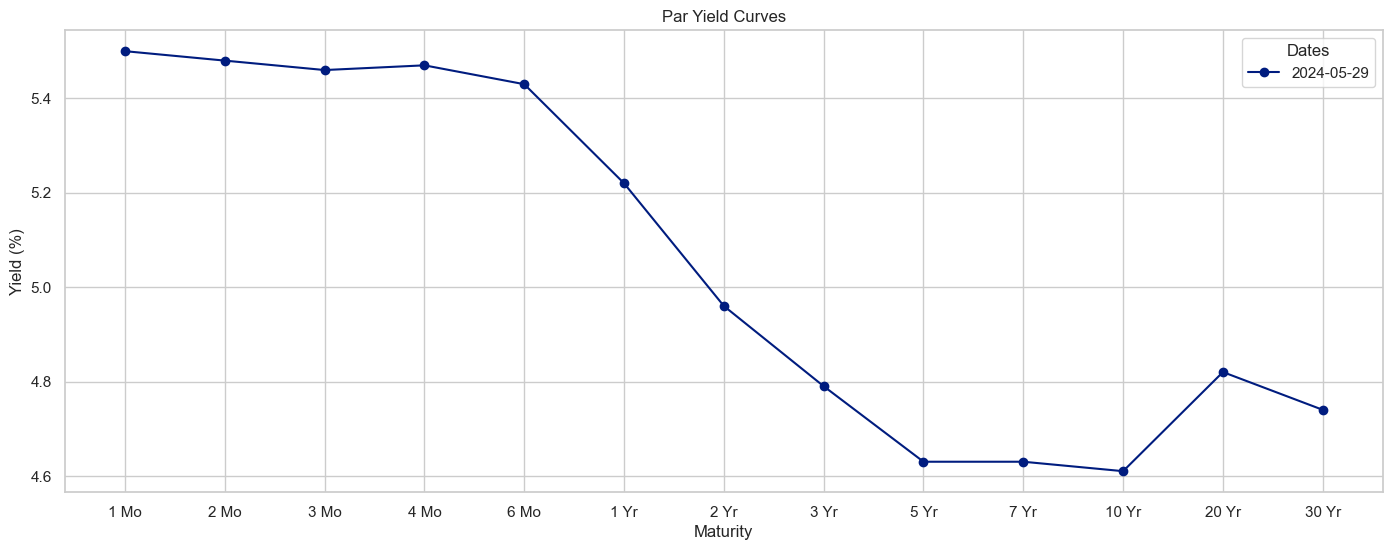

In [108]:
plot_yield_curves(
    df_par_rates,
    dates=[
        datetime(2024, 5, 29),
        # datetime(2024, 4, 23),
        # datetime(2024, 3, 22),
        # datetime(2024, 2, 22),
    ],
    title="Par Yield Curves",
)

In [85]:
! python3.12 schwab_treasuries.py

Historical UST Auctions:
      record_date      cusip  ... tint_cusip_1 tint_cusip_2
3249   2000-01-06  912795ER8  ...         null         null
3250   2000-01-06  912795ES6  ...         null         null
3251   2000-01-06  912795DQ1  ...         null         null
3252   2000-01-13  912795ET4  ...         null         null
3253   2000-01-13  912795DR9  ...         null         null
...           ...        ...  ...          ...          ...
10103  2024-06-04  912797KH9  ...         null         null
10104  2024-06-04  912797KR7  ...         null         null
10105  2024-06-04  912797LK1  ...         null         null
10106  2024-06-06  912797GL5  ...         null         null
10108  2024-06-06  912797LF2  ...         null         null

[5781 rows x 113 columns]
Off the run USTs info to search for:
   record_date      cusip  ...                target_date target_tenor
0   2015-11-16  912828M56  ... 2025-11-21 12:04:31.856105          1.5
1   2016-11-15  912828U24  ... 2026-11-16 12:04:3

In [113]:
df_observed_usts = pd.read_excel("market_observed_treasuries.xlsx")
df_observed_usts = df_observed_usts.sort_values("target_tenor")
df_observed_usts = df_observed_usts[
    (df_observed_usts["target_tenor"] > 0.25)
]
df_observed_usts

,Action,Description,Coupon,Maturity,Quote,Quantity,Price,Min,Max,YTM,YTW 1,Accrued Interest,Estimated Total,Market Depth,CUSIP,target_tenor,time_to_maturity
4,Buy Order will be entered for today’s market,US Treasury BILL 11/21/2024 912797LE5,0.000,11/21/2024,Ask,1000,97.51033,1000,15000,5.356,--,--,975103.33,View for 912797LE5 CUSIP,CUSIP 912797LE5,0.5,0.476712
8,Buy Order will be entered for today’s market,US Treasury BILL 05/15/2025 912797LB1,0.000,05/15/2025,Ask,1000,95.22478,1000,15000,5.181,--,--,952247.78,View for 912797LB1 CUSIP,CUSIP 912797LB1,1.0,0.956164
10,Buy Order will be entered for today’s market,US Treasury 2.25% 11/15/2025 912828M56,2.250,11/15/2025,Ask,300,96.08203,300,10000,5.074,--,293.48,288539.57,View for 912828M56 CUSIP,CUSIP 912828M56,1.5,1.460274
2,Buy Order will be entered for today’s market,US Treasury 4.875% 05/31/2026 91282CKS9 Rece...,4.875,05/31/2026,Ask,500,99.90900,500,81000,4.923,--,--,499545.00,View for 91282CKS9 CUSIP,CUSIP 91282CKS9,2.0,2.000000
11,Buy Order will be entered for today’s market,US Treasury 2% 11/15/2026 912828U24,2.000,11/15/2026,Ask,300,93.55859,300,10000,4.811,--,260.87,280936.65,View for 912828U24 CUSIP,CUSIP 912828U24,2.5,2.460274
5,Buy Order will be entered for today’s market,US Treasury 4.5% 05/15/2027 91282CKR1,4.500,05/15/2027,Ask,525,99.35400,525,46000,4.736,--,1027.17,522635.67,View for 91282CKR1 CUSIP,CUSIP 91282CKR1,3.0,2.956164
12,Buy Order will be entered for today’s market,US Treasury 2.25% 11/15/2027 9128283F5,2.250,11/15/2027,Ask,275,92.31075,275,11000,4.685,--,269.02,254123.58,View for 9128283F5 CUSIP,CUSIP 9128283F5,3.5,3.460274
13,Buy Order will be entered for today’s market,US Treasury 2.875% 05/15/2028 9128284N7,2.875,05/15/2028,Ask,250,93.73000,250,19000,4.627,--,312.5,234637.50,View for 9128284N7 CUSIP,CUSIP 9128284N7,4.0,3.958904
14,Buy Order will be entered for today’s market,US Treasury 1.375% 10/31/2028 91282CDF5,1.375,10/31/2028,Ask,275,87.19922,275,19000,4.612,--,318.53,240116.38,View for 91282CDF5 CUSIP,CUSIP 91282CDF5,4.5,4.421918
7,Buy Order will be entered for today’s market,US Treasury 4.5% 05/31/2029 91282CKT7 Recent...,4.500,05/31/2029,Ask,250,99.72266,250,30000,4.563,--,--,249306.64,View for 91282CKT7 CUSIP,CUSIP 91282CKT7,5.0,5.002740


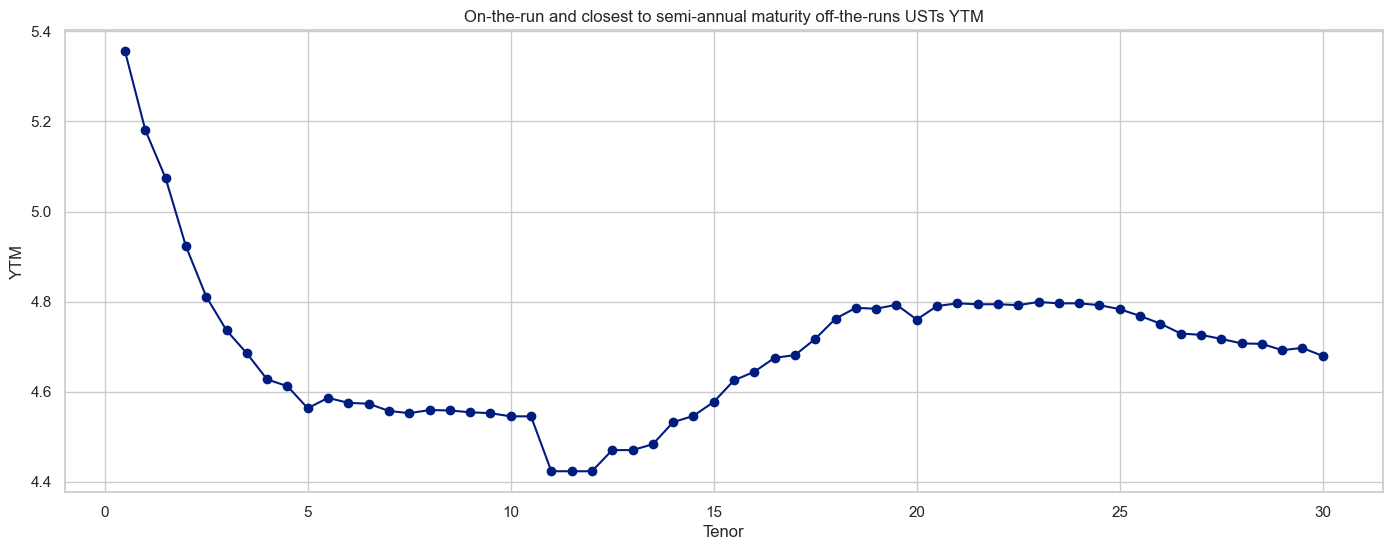

In [114]:
plt.figure(figsize=(17, 6))
plt.plot(df_observed_usts["target_tenor"], df_observed_usts["YTM"], marker="o")
plt.title("On-the-run and closest to semi-annual maturity off-the-runs USTs YTM")
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.show()

In [126]:
depo_maturities = [ql.Period(6,ql.Months), ql.Period(12, ql.Months)]
depo_rates = list(df_observed_usts["YTM"])[:2]

bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,61)]
bond_rates = list(df_observed_usts["YTM"])[2:]

In [152]:
calc_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = calc_date

calendar = ql.UnitedStates(m=ql.UnitedStates.GovernmentBond)
bussiness_convention = ql.Unadjusted
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

depo_helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(r / 100.0)),
        m,
        settlement_days,
        calendar,
        bussiness_convention,
        end_of_month,
        day_count,
    )
    for r, m in zip(depo_rates, depo_maturities)
]

bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(
        calc_date,
        termination_date,
        coupon_frequency,
        calendar,
        bussiness_convention,
        bussiness_convention,
        ql.DateGeneration.Backward,
        end_of_month,
    )

    helper = ql.FixedRateBondHelper(
        ql.QuoteHandle(ql.SimpleQuote(face_amount)),
        settlement_days,
        face_amount,
        schedule,
        [r / 100.0],
        day_count,
        bussiness_convention,
    )
    bond_helpers.append(helper)

rate_helpers = depo_helpers + bond_helpers
yieldcurve = ql.PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)

In [153]:
spots = []
tenors = []
for d in yieldcurve.dates():
    yrs = day_count.yearFraction(calc_date, d)
    compounding = ql.Compounded
    freq = ql.Semiannual
    zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
    tenors.append(yrs)
    eq_rate = zero_rate.equivalentRate(
        day_count, compounding, freq, calc_date, d
    ).rate()
    spots.append(100 * eq_rate)

In [154]:
dates = yieldcurve.dates()
forwards = []
forward_dates = []
forward_period = ql.Period(1, ql.Years)

for d in dates[:-1]:  
    end_date = calendar.advance(d, forward_period)
    if end_date > dates[-1]:
        break
    
    fwd_rate = yieldcurve.forwardRate(d, end_date, day_count, compounding, freq, True).rate()
    forwards.append(fwd_rate * 100)  
    forward_dates.append(d)

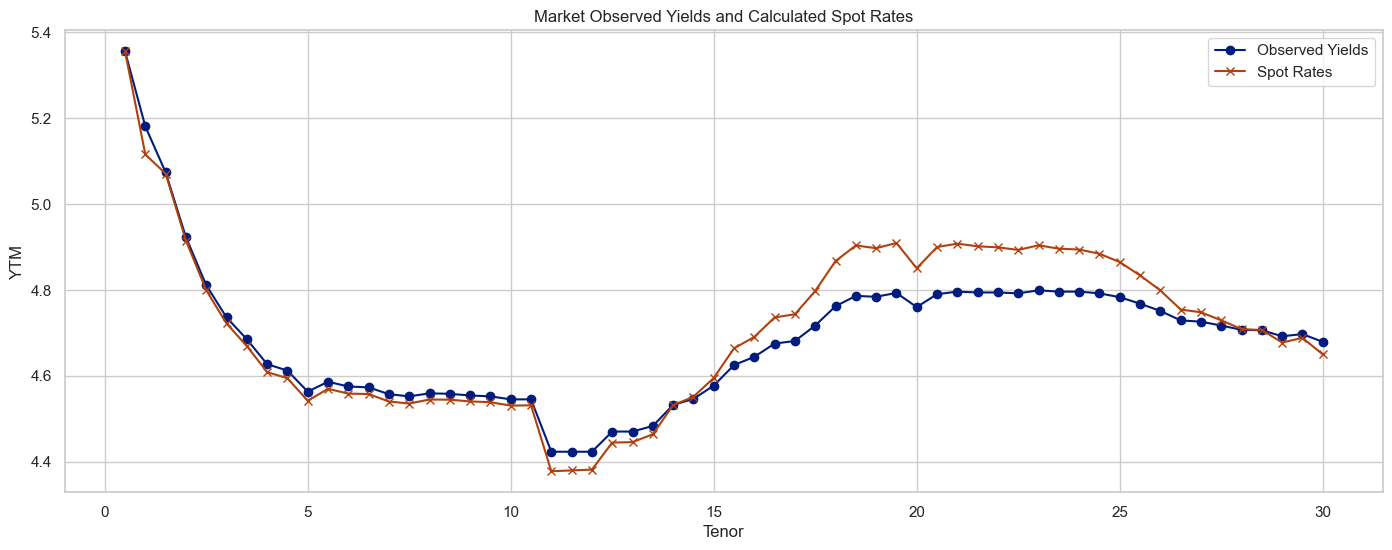

In [163]:
plt.figure(figsize=(17, 6))
plt.plot(df_observed_usts["target_tenor"], df_observed_usts["YTM"], marker="o", label="Observed Yields")
plt.plot(list(df_observed_usts["target_tenor"]), spots[1:], marker="x", label="Spot Rates")
# plt.plot(list(df_observed_usts["target_tenor"])[2:], forwards, marker="x", label="Forward Rates")
plt.title("Market Observed Yields and Calculated Spot Rates")
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()